# Computer Vision
## Exercise Sheet 3: Image Center, Edges, Keypoints
### Erhardt Barth / Philipp Gruening / Christoph Linse / Manuel Laufer
Universität zu Lübeck, Institut für Neuro- und Bioinformatik

In case of questions, contact us via email: *{barth, gruening, linse, laufer} @inb.uni-luebeck.de*

## Note: Please insert the names of all participating students:

1. 
2. 
3. 
4. 
5. 


In [16]:
import sys, os
if 'google.colab' in sys.modules:
  if os.getcwd() == '/content':
    !git clone 'https://github.com/inb-luebeck/cs4250.git'
    os.chdir('cs4250')

In [17]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import dilation

%matplotlib inline

## Exercise 3.1
### Finding the Image Center
Camera calibration refers to the process of computing the intrinsic and extrinsic parameters of the camera. It is a necessary step in many computer vision applications such as 3D scene reconstruction and recognition. One important intrinsic parameter is the image center. Print out the images `ueb311.jpg` and `ueb312.jpg` and estimate the image centers by using a ruler.

**Hint**: Make small printouts of the images to have enough space around them.

In [18]:
def load_image_gray(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

In [19]:
def load_image_gray_normalized(image_path):
    return load_image_gray(image_path).astype('float32')/255.

In [20]:
def gradient(image):
    v = .5
    k_y = np.zeros((3, 3))
    k_y[0, 1] = -v
    k_y[2, 1] = +v

    k_x = np.zeros((3, 3))
    k_x[1, 0] = -v
    k_x[1, 2] = +v

    image = np.copy(image).astype('float32')

    gradient_x = cv2.filter2D(image, -1, k_x)
    gradient_y = cv2.filter2D(image, -1, k_y)

    return gradient_x, gradient_y


## Exercise 3.2.1
### Edge Detection
Open the image `ueb32.jpg` in Python and show the image gradients $d_x$ and $d_y$. Compute the magnitude of gradients image and apply a threshold to retain only the edges of the object. For those edges, compute and show the gradient angle image (`np.arctan2`). How can you tell the angle of the gradient from looking only at the gradients?

In [21]:
def display_with_hist(image):

  plt.figure(figsize=(12,6))
  plt.subplot(2,1,1)
  plt.imshow(image,cmap='gray')
  plt.subplot(2,1,2)
  plt.hist(image.flatten(), 256)
  plt.show()

np.min(angle_image) = -179.40318; np.max(angle_image) = 180.0


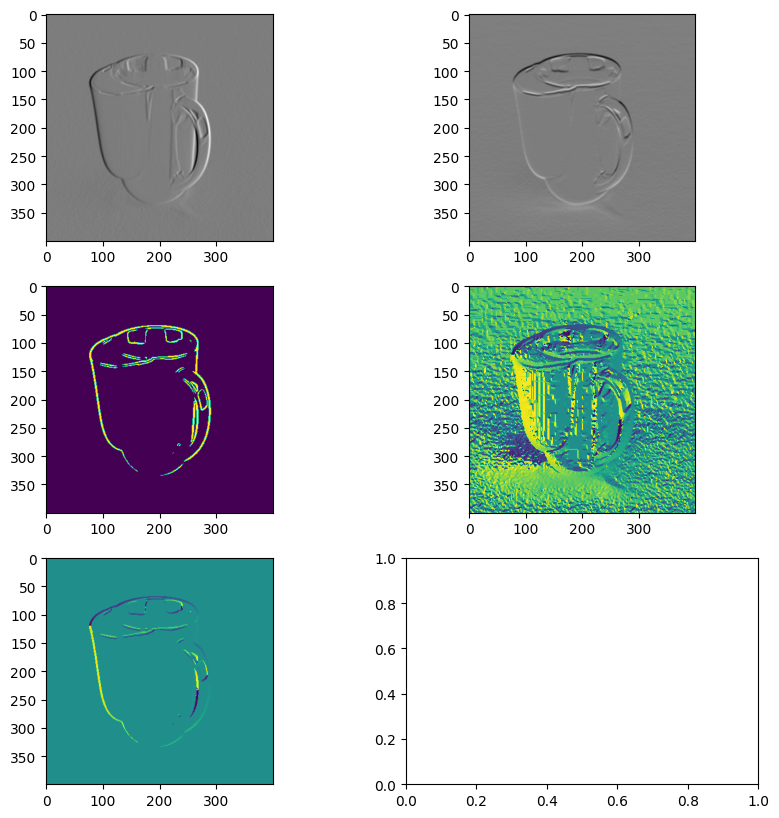

In [22]:
import copy
# load image
img = load_image_gray('./data/exercise_3/ueb32.jpg')

# smooth image
smooth_img = cv2.GaussianBlur(img, (5, 5), 0)

# compute and show gradient images 
# make images comparable
gradient_x, gradient_y = gradient(smooth_img)
lo = min(np.min(gradient_x), np.min(gradient_y))
hi = max(np.max(gradient_x), np.max(gradient_y))
fig, axs = plt.subplots(3,2, figsize = (10, 10))
axs[0,0].imshow(gradient_x, cmap='gray', vmin=lo, vmax = hi)
axs[0,1].imshow(gradient_y, cmap='gray', vmin=lo, vmax = hi)
#display_with_hist(gradient_x)

# compute gradient magnitude
threshold = 15
magnitude_of_gradient = np.sqrt(np.square(gradient_x) + np.square(gradient_y))
threshold_of_magnitude = copy.deepcopy(magnitude_of_gradient)
threshold_of_magnitude[threshold_of_magnitude < threshold] = 0
threshold_of_magnitude[threshold_of_magnitude != 0] = 1
axs[1,0].imshow(threshold_of_magnitude)

# compute an angle image that should be in range [-180,+180]
angle_image = np.arctan2(gradient_y, gradient_x)
angle_image = angle_image * 180 / np.pi
print(f'{np.min(angle_image) = }; {np.max(angle_image) = }')
axs[1,1].imshow(angle_image)

# show angles only for real edges
real_angles = np.multiply(angle_image, threshold_of_magnitude)
axs[2,0].imshow(real_angles)

## Exercise 3.2.2
### Canny Edge Detector
Open the image `ueb32.jpg` in Python and use the OpenCV Canny algorithm to find the edges in the image.
Compare the result with the magnitude of gradient image. Display both results side by side using `plt.subplots`.
Comment on how the two results differ and why.**Furthermore, comment how the angle image and the magnitude image are used in the Canny algorithm.**

(-0.5, 399.5, 399.5, -0.5)

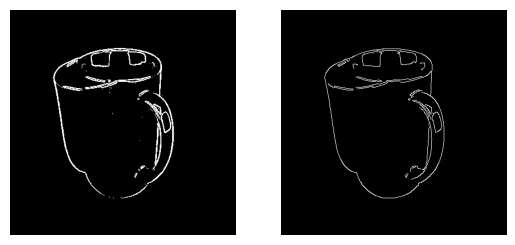

In [23]:
# load image
img = load_image_gray('./data/exercise_3/ueb32.jpg')

# compute magnitude of gradient image
gradient_x, gradient_y = gradient(img)

threshold = 18
magnitude_of_gradient = np.sqrt(np.square(gradient_x) + np.square(gradient_y))
threshold_of_magnitude = copy.deepcopy(magnitude_of_gradient)
threshold_of_magnitude[threshold_of_magnitude < threshold] = 0
threshold_of_magnitude[threshold_of_magnitude != 0] = 1
# apply canny
canny = cv2.Canny(img, 100, 200)
# compare results

fig, axs = plt.subplots(1,2)
axs[0].imshow(threshold_of_magnitude, cmap='gray')
axs[0].axis("off")
axs[1].imshow(canny, cmap='gray')
axs[1].axis("off")

## Exercise 3.3
### Key Point Detection
Implement the following key-point detectors:
* local maxima of $K$
* local maxima of $K$ − $\alpha$ $H^2$, with $\alpha$ as weighting parameter

The function is supposed to return images of the same size as the input, where the pixels contain $K$ or $K$ − $\alpha$ $H^2$.

$K$ and $H$ should be the invariants of the structure tensor $J$ (see script).
Evaluate the detectors above on two kinds of test images: (i) the synthetic image `ueb331.npy`, (ii) the
picture `ueb332.jpg`.

Comment your results with a focus on
1. the localization of the key points
2. the influence of the $H$ term as controlled via the parameter $\alpha$.

**Question**: Why do you filter the image with a Gaussian kernel a second time? It is **not** about noise removal!

**Hint**: Use the provided functions `find_local_max` and `plot_marks`.

In [61]:
def find_local_max(keypoints, thres=1e-6, k=3):
    kernel = np.ones((k, k))
    kernel[k//2, k//2] = 0
    local_max = keypoints > thres + dilation(keypoints, kernel)

    return local_max

In [25]:
def plot_marks(map, ax=None):
    if ax is None:
        _, ax = plt.subplots(1)
    col, row = np.nonzero(map)

    ax.plot(row, col, 'r.')

In [59]:
def key_points_structure(image, alpha, sigma=.1):
    # image parameters
    width = image.shape[0]
    height = image.shape[1]

    # 0. filter with Gaussian kernel with sigma
    smooth_img = cv2.GaussianBlur(image, ksize=(0, 0), sigmaX=sigma, sigmaY=sigma)

    # 1. partial derivatives
    gradient_x, gradient_y = gradient(smooth_img)

    # 2. product images
    x_2 = gradient_x**2 
    xy = gradient_x * gradient_y
    y_2 = gradient_y**2

    # 3. filter with gaussian kernel with sigma = 1
    smooth_x_2 = cv2.GaussianBlur(x_2, ksize=(0, 0), sigmaX=1, sigmaY=1)
    smooth_xy = cv2.GaussianBlur(xy, ksize=(0, 0), sigmaX=1, sigmaY=1)
    smooth_y_2 = cv2.GaussianBlur(y_2, ksize=(0, 0), sigmaX=1, sigmaY=1)

    # 4. compute invarians for J
    #J = np.array([[smooth_x_2, smooth_xy], [smooth_xy, smooth_y_2]])
    J = np.empty_like(smooth_x_2)
    K = np.empty_like(smooth_x_2)
    H = np.empty_like(smooth_x_2)
    for i, j in np.ndindex(J.shape):
      J = np.array([[smooth_x_2[i, j], smooth_xy[i, j]], [smooth_xy[i, j], smooth_y_2[i, j]]])
      H[i, j] = np.trace(J)
      K[i, j] = np.linalg.det(J)

    print(H[0, 0])
    return K, K-alpha * H**2
    

0.014745484
4.5026385e-07
-3.0213123e-05


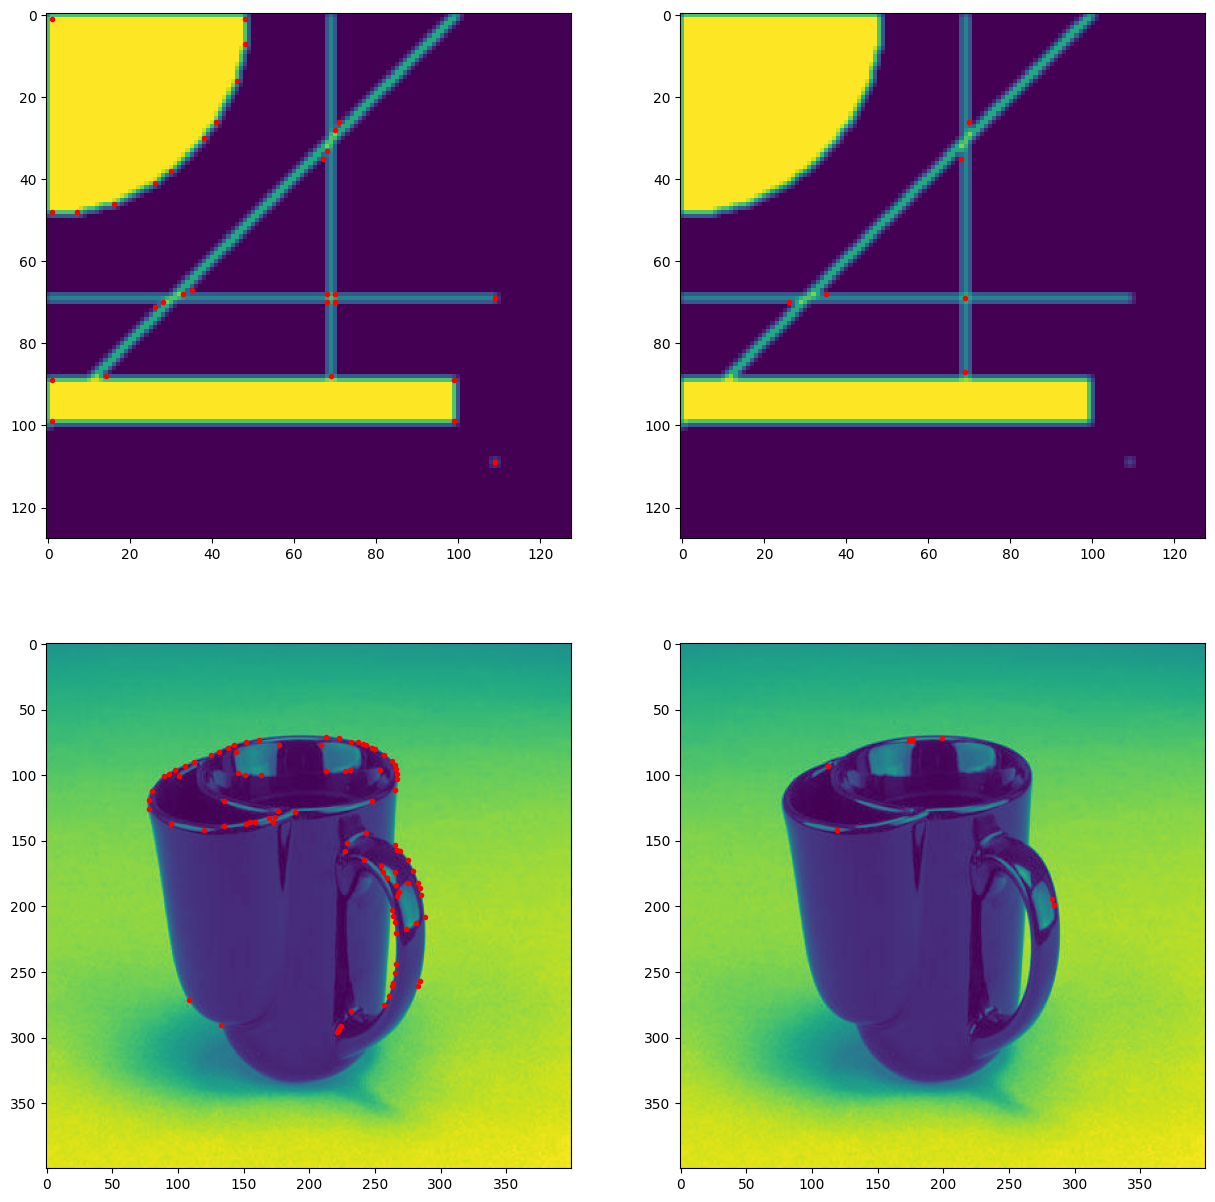

In [62]:
# define alpha, sigma, and k
alpha = 0.3
sigma = 0.1


# load images
img_331 = np.load('./data/exercise_3/ueb331.npy')
img_332 = load_image_gray_normalized('./data/exercise_3/ueb332.jpg')

# extract keypoints
K_1, K_minus_H_1 = key_points_structure(img_331, alpha, sigma)
K_2, K_minus_H_2 = key_points_structure(img_332, alpha, sigma)
print(K_minus_H_1[0, 0])
# show found keypoints (K, K_minus_H) for both images
# example
_, ax = plt.subplots(2, 2, figsize=(15, 15))
local_max = find_local_max(K_1)
ax[0][0].imshow(img_331)
plot_marks(local_max, ax[0][0])

local_max = find_local_max(K_minus_H_1)
ax[0][1].imshow(img_331)
plot_marks(local_max, ax[0][1])

local_max = find_local_max(K_2)
ax[1][0].imshow(img_332)
plot_marks(local_max, ax[1][0])

local_max = find_local_max(K_minus_H_2)
ax[1][1].imshow(img_332)
plot_marks(local_max, ax[1][1])